” using only pytorch’s
tensor operations and the standard math library

Your framework should import only torch.empty



In [1]:
from torch import empty
import math
import torch

torch.set_grad_enabled(False) #turns off autograd


Your framework must provide the necessary tools to:
 build networks combining fully connected layers, Tanh, and ReLU,
 run the forward and backward passes,
 optimize parameters with SGD for MSE

You must implement a test executable named test.py that imports your framework and
 Generates a training and a test set of 1, 000 points sampled uniformly in [0, 1]2
, each with a
label 0 if outside the disk centered at (0.5, 0.5) of radius 1/
√
2π, and 1 inside,
 builds a network with two input units, two output units, three hidden layers of 25 units,
 trains it with MSE, logging the loss,
 computes and prints the final train and the test errors.

In [2]:
#Structure is better if original

class Module ( object ) :

    def forward ( self , * input ) :
        raise NotImplementedError
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    def param ( self ) :
        return self.params

In [3]:
class Parameter(object):
    def __init__(self, data, grad=0, x=None ):
        super(Parameter, self).__init__()
        self.data = data
        self.grad = grad
        self.input = x

In [4]:
class lossMSE(Module):
    def __init__(self):
        super(lossMSE, self).__init__()
        self.name = 'MSE_loss'
    def forward(self, input, target):
        return input.sub(target).pow(2).mean() 
    def backward(self, input, target):
        return input.sub(target.view(-1,input.shape[1])).mul(2)

In [5]:
class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()
        self.name = 'ReLU'
        self.params = Parameter(None)
    def forward(self, input):
        self.params.input = input
        return input.clamp(min = 0)
    def backward(self, gradwrtoutput):
        return self.params.input.sign().add(1).div(2) * gradwrtoutput

In [6]:
class Tanh(Module):
    def __init__(self,x = None):
        super(Tanh,self).__init__()
        self.name = 'Tanh'
        self.params = Parameter(None)
    def forward(self, input):
        self.params.input = input
        return input.tanh()
    def backward(self, gradwrtoutput):
        return (1 - self.params.input.tanh().pow(2)).mul(gradwrtoutput)
        

In [7]:
class SoftMax(Module):
    def __init__(self,in_dim,beta = 1):
        self.params = Parameter(None)
        self.beta = beta
        
    def forward(self, x):
        self.params.input = torch.exp(x) / torch.exp(x).sum(axis=1).unsqueeze(1)
        return  self.params.input
    
    def backward(self, gradwrtoutput):
        return self.params.input*(1 - self.params.input) * gradwrtoutput
    

In [168]:
class Linear(Module):
    def __init__(self,in_dim, out_dim,bias=True,dropout = 0,init='xavier'):
        self.bias = bias
        if self.bias:
            self.params = Parameter(torch.randn((in_dim + 1,out_dim))/(math.sqrt(in_dim /2)))
        else:
            self.params = Parameter(torch.randn((in_dim,out_dim))/(math.sqrt(in_dim/2)))
        if dropout > 0:
            self.dropout = dropout
        else:
            self.dropout = None
        
    
    def forward(self, x):
        if self.dropout is not None:
            self.non_zero = torch.bernoulli(self.dropout * torch.ones((self.params.data.size(1),)))
        else:
            self.non_zero = torch.ones((self.params.data.size(1),))
            
        if self.bias:
            self.params.input = torch.cat((x,torch.ones((x.size(0),1))),dim=1)    
        else:
            self.params.input = x
        return  (self.params.input @self.params.data)* self.non_zero
    
    
    def backward(self, gradwrtoutput): 
        self.params.grad = torch.bmm((gradwrtoutput*self.non_zero).unsqueeze(-1) , self.params.input.unsqueeze(-2)).mean(axis=0).t()
        if self.bias:
            return ((gradwrtoutput*self.non_zero) @ self.params.data.t())[:,:-1]
        else:
            return (gradwrtoutput*self.non_zero) @ self.params.data.t()
    

In [ ]:
class BatchNorm(Module):
    def __init__(self,dim):
        self.params = 

In [9]:
class Sequential(Module):
    def __init__(self, *modules):
        super(Sequential, self).__init__()
        self.modules = modules
        self.params = []
        for mod in self.modules:
            if mod.param() is not None:
                self.params.append(mod.param())
        
            
    def forward(self, input):
        for mod in self.modules:
            input = mod.forward(input)
        return input
    
    def backward(self, gradwrtoutput):
        for mod in reversed(self.modules):
            gradwrtoutput = mod.backward(gradwrtoutput)


In [20]:
class SGD_opti(object):
    def __init__(self, model_parameters, learn_rate = 1e-3,beta = 0.9):
        self.lr = learn_rate
        self.param_to_update= [{'param': p,'update': torch.zeros_like(p.data)} for p in model_parameters if p.data is not None]
        self.beta = beta
        self.steps = 0
    
    def step(self):
        for p in self.param_to_update:
            if p['param'].data is not None:
                if self.steps ==0:
                    p['update'] = p['param'].grad
                else:
                    p['update'] = self.beta * p['update'] + (1-self.beta)*p['param'].grad 
                p['param'].data -= self.lr*p['update']
        self.steps+=1
        
                
    def zero_grad(self):
        for p in self.param_to_update:
            p['param'].input = None
            p['param'].grad = None

In [52]:
class Adam_opti(object):
    def __init__(self, model_parameters, learn_rate = 1e-3,beta1 = 0.9,beta2 = 0.999, eps = 1e-8):
        self.lr = learn_rate
        self.param_to_update= [{'param': p,'m': torch.zeros_like(p.data), 'v': torch.zeros_like(p.data)} for p in model_parameters if p.data is not None]
        self.beta1 = beta1
        self.steps = 0
        self.beta2 = beta2
        self.eps = eps
    
    def step(self):
        for p in self.param_to_update:
            if p['param'].data is not None:
                p['m'] = self.beta1 * p['m'] + (1-self.beta1)*p['param'].grad
                p['v'] = self.beta2 * p['v'] + (1-self.beta2)*p['param'].grad.pow(2)
                p['param'].data -= self.lr*(p['m']*(1- self.beta2)/((1-self.beta1) *(p['v'] + (1- self.beta2)*self.eps)))
        self.steps+=1
        
                
    def zero_grad(self):
        for p in self.param_to_update:
            p['param'].input = None
            p['param'].grad = None

In [107]:
class LR_scheduler(object):
    def __init__(self, optimizer, gamma=0.1,counter = 30):
        self.optimizer = optimizer
        self.gamma = gamma
        self.counter = counter
        self.steps = 0
        self.curr_count = counter
        
    def step(self):
        self.steps+=1
        if self.steps > self.curr_count:
            self.optimizer.lr *= self.gamma
            self.curr_count += self.counter


In [108]:
def generate_disc_set(nb):
    data = empty(nb,2).uniform_(0,1)
    target = (data-0.5).pow(2).sum(1).sub(1/(2*math.pi)).sign()
    #.add(1).div(2)
    
    return data, target

In [109]:
def convert_to_one_hot_labels(target):
    hot_labels = empty(target.size(0), 2)
    hot_labels[:,0], hot_labels[:,1] = 1-target, target 
    return hot_labels

In [178]:
model = Sequential(Linear(2, 25,dropout = 0.1), ReLU(),Linear(25, 25,dropout = 0.1), ReLU(),Linear(25, 25, dropout = 0.1), ReLU(),Linear(25, 1), Tanh())

# Setting the training parameter
mini_batch_size, epochs, lr = 50, 1000, 1e-3
criterion = lossMSE()
optimi = SGD_opti(model.param(), learn_rate=lr)
scheduler = LR_scheduler(optimi,counter = epochs/4, gamma = 0.5)


# Generating the train and test datasets
nb_samples = 1000

train_input, train_target = generate_disc_set(nb_samples)
train_hot = convert_to_one_hot_labels(train_target)


test_input, test_target = generate_disc_set(nb_samples)
test_hot = convert_to_one_hot_labels(test_target)



In [179]:
def compute_nb_acc(model, data_input, data_target):
    # Function that returns the number of errors
    nb_acc = 0
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        predicted_classes,_ = output.max(1)
        nb_acc = nb_acc + (data_target.narrow(0, b, mini_batch_size).eq(predicted_classes.sign())).sum()
    return nb_acc*100.0/data_input.size()[0]


In [180]:
import tqdm
loss_list = []
train_acc_list = []
test_acc_list = []
for e in tqdm.tqdm(range(0, epochs)):
    sum_loss = 0
    for b in range(0, train_input.size(0), mini_batch_size):
        optimi.zero_grad()
        output = model.forward(train_input.narrow(0, b, mini_batch_size))
        loss = criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
        sum_loss+= loss
        first_grad = criterion.backward(output, train_target.narrow(0, b, mini_batch_size))
        model.backward(first_grad)
        optimi.step()
    scheduler.step()
    loss_list.append(sum_loss.item()/train_input.size(0))
    train_acc = compute_nb_acc(model, train_input, train_target)
    test_acc = compute_nb_acc(model, test_input, test_target)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    #if e%100 == 99:
    #    print(train_error)
    #    print(test_error)
    #    print(loss_list[e])
        

100%|██████████| 1000/1000 [00:43<00:00, 22.93it/s]


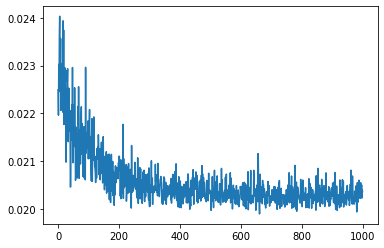

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(loss_list)),loss_list)

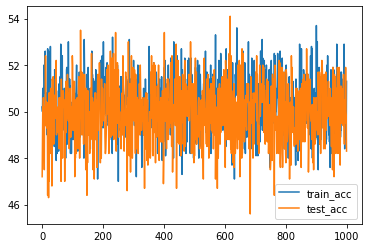

In [181]:
plt.plot(range(len(train_acc_list)), train_acc_list,label="train_acc")
plt.plot(range(len(test_acc_list)),test_acc_list,label="test_acc")
plt.legend()

tensor(86.1000)
tensor(86.7000)


tensor(515)

In [19]:
def train_model(model, train_input, train_target):
    # train function
    loss_list = []
    for e in range(0, epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            loss = criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
            sum_loss+= loss
            model.zero_grad()
            first_grad = criterion.backward(output, train_target.narrow(0, b, mini_batch_size))
            model.backward(first_grad)
            optimi.step()
        loss_list.append(sum_loss.item())
    return loss_list

In [75]:
data,target = generate_disc_set(1000)

In [76]:
data.size()

torch.Size([1000, 2])

In [ ]:
FOLLOWING OF TRAINING :
# Creating the model
model = Sequential(Linear(2, 25), ReLU(),Linear(25, 25), ReLU(),Linear(25, 25), ReLU(),Linear(25, 2), Tanh())

# Setting the training parameter
mini_batch_size, epochs, lr = 50, 50, 1e-3

criterion = lossMSE()
optimi = SGD_opti(model.param(), learn_rate=lr)

# Training
l_list = train_model(model, train_input, train_hot)


def compute_nb_errors(model, data_input, data_target):
    # Function that returns the number of errors
    nb_errors = 0
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batchsize))
        , predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if data_target[b + k].long() != predicted_classes[k]:
                nb_errors = nb_errors + 1
    return nb_errors

# Computing the number of errors on both datasets
train_error = compute_nb_errors(my_mod, train_input, train_target)
test_error = compute_nb_errors(my_mod, test_input, test_target)
IF A XAVIER INITIALIZATION IS NEEDED :

In [81]:
from torch import empty
#from framework import *
import math
import torch

torch.set_grad_enabled(False);



# Generating the train and test datasets
nb_samples = 1000

train_input, train_target = generate_disc_set(nb_samples)
train_hot = convert_to_one_hot_labels(train_target)

test_input, test_target = generate_disc_set(nb_samples)
test_hot = convert_to_one_hot_labels(test_target)


def train_model(model, train_input, train_target):
    # train function
    loss_list = []
    for e in range(0, epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            loss = criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
            sum_loss+= loss
            model.zero_grad()
            first_grad = criterion.backward(output, train_target.narrow(0, b, mini_batch_size))
            model.backward(first_grad)
            optimi.step()
        loss_list.append(sum_loss.item())
    return loss_list

torch.Size([1000])

 Generates a training and a test set of 1, 000 points sampled uniformly in [0, 1]2
, each with a
label 0 if outside the disk centered at (0.5, 0.5) of radius 1/
√
2π, and 1 inside,


def generate_disk_set(nb):
    input = Tensor(nb, 1).uniform_(0, 1)
    target = input.pow(2).sum(1).sub(1 / math.pi).sign().add(1).div(2).long()
    return input, target

train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

mean, std = train_input.mean(), train_input.std()

train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

mini_batch_size = 100

 builds a network with two input units, two output units, three hidden layers of 25 units

that returns a mlp with 2 input units, hidden layers of sizes respectively 4, 8, 16, 32, 64, 128, and 2
output units





def create_shallow_model():
    return nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )

def create_deep_model():
    return nn.Sequential(
        nn.Linear(2, 4),
        nn.ReLU(),
        nn.Linear(4, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )

forward and backward ?

def forward_pass(w1, b1, w2, b2, x):
    x0 = x
    s1 = w1.mv(x0) + b1
    x1 = sigma(s1)
    s2 = w2.mv(x1) + b2
    x2 = sigma(s2)

    return x0, s1, x1, s2, x2

def backward_pass(w1, b1, w2, b2,
                  t,
                  x, s1, x1, s2, x2,
                  dl_dw1, dl_db1, dl_dw2, dl_db2):
    x0 = x
    dl_dx2 = dloss(x2, t)
    dl_ds2 = dsigma(s2) * dl_dx2
    dl_dx1 = w2.t().mv(dl_ds2)
    dl_ds1 = dsigma(s1) * dl_dx1

    dl_dw2.add_(dl_ds2.view(-1, 1).mm(x1.view(1, -1)))
    dl_db2.add_(dl_ds2)
    dl_dw1.add_(dl_ds1.view(-1, 1).mm(x0.view(1, -1)))
    dl_db1.add_(dl_ds1)
    
    #ensuite utilisé dans la partie 4 de practical 3